Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
#read dataset
pics_dataset=tf.keras.utils.image_dataset_from_directory(data_dir_train,labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height,img_width),
    seed=123)

Found 2239 files belonging to 9 classes.


In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(img_height,img_width), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [12]:
### your code goes here, you can use training or validation data to visuali
import matplotlib.pyplot as plt
label=pics_dataset.class_names
import matplotlib.pyplot as plt
#q=mel_dataset.class_names
index=1
label_dict = {key: 0 for key in label}
plt.figure(figsize=(10,10))
for images,labels in pics_dataset:
    label1=labels[0]
    class_index=tf.argmax(label1)
    if(label_dict[label[class_index]]==0):
        image=images[0]
        plt.subplot(3,3,index)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(label[class_index])
        index=index+1
        label_dict[label[class_index]]+=1
plt.show()
### your code goes here, you can use training or validation data to visualize

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-8ebdd4f32a38>", line 9, in <cell line: 9>
    for images,labels in pics_dataset:
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 809, in __next__
    return self._next_internal()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 772, in _next_internal
    ret = gen_dataset_ops.iterator_get_next(
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 3023, in iterator_get_next
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2

TypeError: ignored

<Figure size 1000x1000 with 0 Axes>

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
# Create a Sequential model
Model= Sequential()

# Normalize pixel values between (0, 1) using Rescaling
Model.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Add Convolutional and Pooling Layers

Model.add(Conv2D(32,(3,3),activation='relu')) #--> remove padding
Model.add(MaxPooling2D(pool_size=(2, 2)))
Model.add(Conv2D(64,(3,3),activation='relu'))
Model.add(MaxPooling2D(pool_size=(2, 2)))
Model.add(Conv2D(64,(3,3),activation='relu'))
Model.add(MaxPooling2D(pool_size=(2, 2)))
Model.add(Conv2D(128,(3,3),activation='relu'))
Model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to transition from convolutional to densely connected layers
Model.add(layers.Flatten())

# Dense layers for classification
Model.add(layers.Dense(155,activation='relu'))
Model.add(layers.Dense(len(pics_dataset.class_names),activation='softmax'))

#To summary the model
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        3

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
Model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [13]:
# View the summary of all layers
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        3

### Train the model

In [14]:
epochs = 20
history = Model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 587s 9s/step - loss: 1.9526 - accuracy: 0.2885 - val_loss: 1.7060 - val_accuracy: 0.3937
Epoch 2/20
56/56 [==============================] - 17s 278ms/step - loss: 1.6314 - accuracy: 0.4163 - val_loss: 1.6088 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 17s 280ms/step - loss: 1.5697 - accuracy: 0.4314 - val_loss: 1.4984 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 17s 279ms/step - loss: 1.4923 - accuracy: 0.4688 - val_loss: 1.4380 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 17s 276ms/step - loss: 1.4284 - accuracy: 0.5084 - val_loss: 1.4538 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 17s 276ms/step - loss: 1.4318 - accuracy: 0.4883 - val_loss: 1.4272 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 17s 268ms/step - loss: 1.3356 - accuracy: 0.5301 - val_loss: 1.3781 - val_accuracy: 0.5034
E

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
history = Model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
56/56 [==============================] - 18s 81ms/step - loss: 0.6779 - accuracy: 0.7489 - val_loss: 1.8079 - val_accuracy: 0.5503
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 0.5559 - accuracy: 0.7997 - val_loss: 1.7333 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 0.5753 - accuracy: 0.7874 - val_loss: 1.8061 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 2s 36ms/step - loss: 0.4853 - accuracy: 0.8214 - val_loss: 2.2037 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 2s 37ms/step - loss: 0.4747 - accuracy: 0.8276 - val_loss: 2.0825 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 2s 36ms/step - loss: 0.3909 - accuracy: 0.8532 - val_loss: 2.1957 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 0.3568 - accuracy: 0.8638 - val_loss: 2.6000 - val_accuracy: 0.4698
Epoch 8/20
5

### Visualizing training results

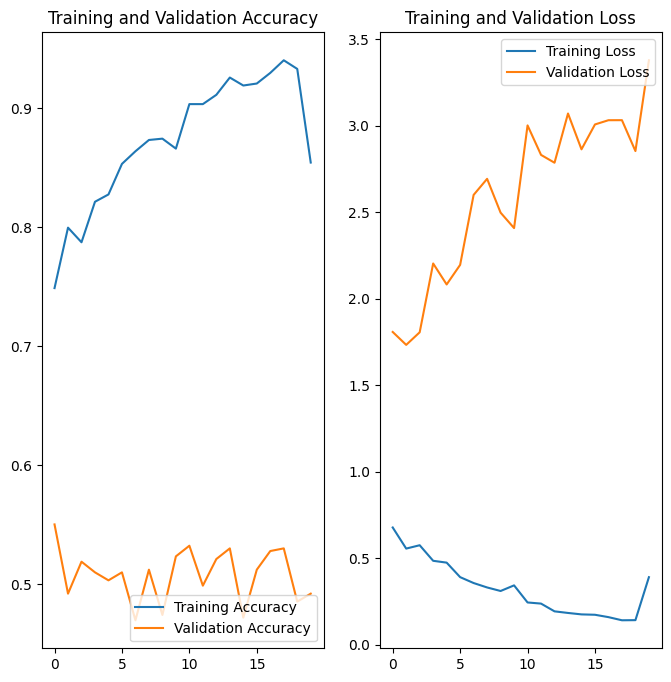

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
train_ds_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
   layers.experimental.preprocessing.RandomRotation(0.5),
  ]
)

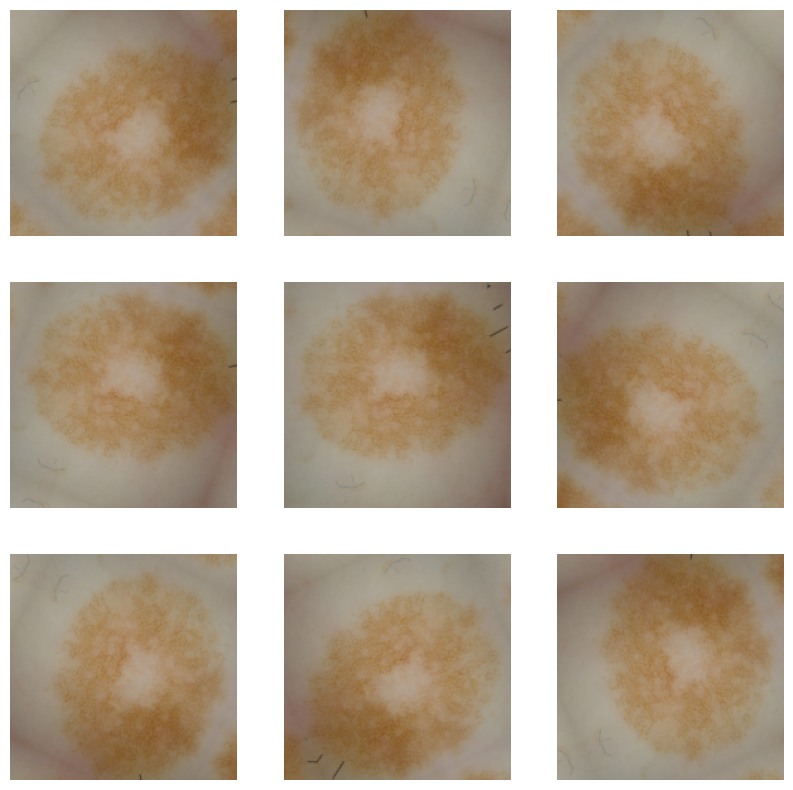

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = train_ds_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model_after_augmentation = Sequential([
  train_ds_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(155, 3, padding='same', activation='relu'),
  layers.Flatten(),
  layers.Dense(155, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(len(pics_dataset.class_names))
])
model_after_augmentation.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

### Compiling the model

In [21]:
model_after_augmentation.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
epochs = 20
history1 = model_after_augmentation.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 9s 67ms/step - loss: 3.8824 - accuracy: 0.1758 - val_loss: 2.1695 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 3s 59ms/step - loss: 7.6854 - accuracy: 0.1814 - val_loss: 10.0600 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 7.9264 - accuracy: 0.1847 - val_loss: 9.9882 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 7.9511 - accuracy: 0.1892 - val_loss: 6.1299 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 7.1381 - accuracy: 0.1596 - val_loss: 6.1299 - val_accuracy: 0.1924
Epoch 6/20
56/56 [==============================] - 3s 62ms/step - loss: 8.2131 - accuracy: 0.1367 - val_loss: 9.9882 - val_accuracy: 0.1790
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 7.9072 - accuracy: 0.1289 - val_loss: 6.1299 - val_accuracy: 0.1790
Epoch 8/20
5

### Visualizing the results

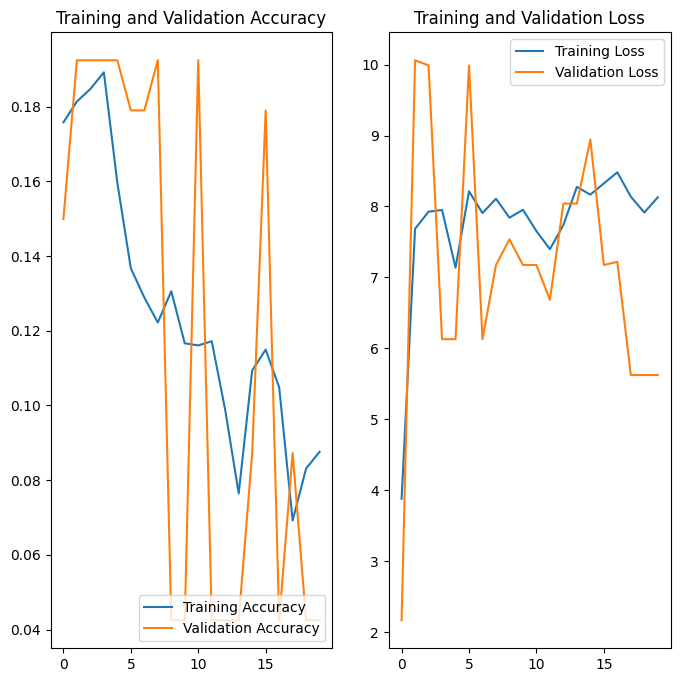

In [23]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
import os

def class_count(dir):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(dir).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    #name of the classes
    sub_directory = [name for name in os.listdir(dir)
                    if os.path.isdir(os.path.join(dir, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'Num of images'])

df = class_count(data_dir_train)
df

,Class,Num of images
0,seborrheic keratosis,77
1,squamous cell carcinoma,181
2,melanoma,438
3,actinic keratosis,114
4,nevus,357
5,basal cell carcinoma,376
6,pigmented benign keratosis,462
7,vascular lesion,139
8,dermatofibroma,95


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


seborrheic keratosis	 class  has 77 num of images.This is the least one.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
import Augmentor

In [30]:
from Augmentor import Pipeline
path_to_training_dataset= "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
print(pics_dataset.class_names)
for i in pics_dataset.class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,path_to_training_dataset+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EBC8673FD60>: 100%|██████████| 500/500 [00:19<00:00, 25.63 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EBC86763D90>: 100%|██████████| 500/500 [00:17<00:00, 29.19 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EBCF2A00DC0>: 100%|██████████| 500/500 [00:18<00:00, 27.55 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EBCF2B07D60>: 100%|██████████| 500/500 [01:31<00:00,  5.46 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7EBC867BFA30>: 100%|██████████| 500/500 [01:11<00:00,  6.99 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EBCF2BB6B60>: 100%|██████████| 500/500 [00:17<00:00, 28.04 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EBCF2A00EE0>: 100%|██████████| 500/500 [00:39<00:00, 12.68 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EBCF2B04E50>: 100%|██████████| 500/500 [00:17<00:00, 28.42 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EBC867197B0>: 100%|██████████| 500/500 [00:18<00:00, 26.87 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [51]:
import glob
from glob import *
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

AttributeError: ignored

### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
import glob
from glob import *
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

[]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  label_mode="categorical",
  batch_size=batch_size)

NotFoundError: ignored

#### **Todo:** Create a validation dataset

In [ ]:
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

